### Ritajit Majumdar
Quantum Enablement and Engineering Team @IBM Quantum

### Running a circuit with Qiskit primitives

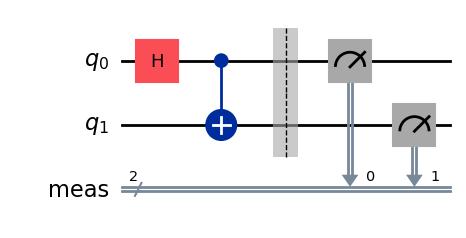

In [1]:
from qiskit import QuantumCircuit, QuantumRegister

# Initialize the qubits
qubits = QuantumRegister(2, name="q")

# Create the circuit
circuit = QuantumCircuit(qubits)

# Unpack the qubits
q0, q1 = qubits

# Add the Hadamard and CNOT gates to the circuit
circuit.h(q0)
circuit.cx(q0, q1)
circuit.measure_all()

circuit.draw("mpl")

#### Running on a sampler primitive

In [2]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2

In [3]:
sampler = SamplerV2(backend=AerSimulator())
sampler.options.default_shots = 10000

In [4]:
job = sampler.run([circuit])

In [5]:
result = job.result()[0]
counts = result.data.meas.get_counts()

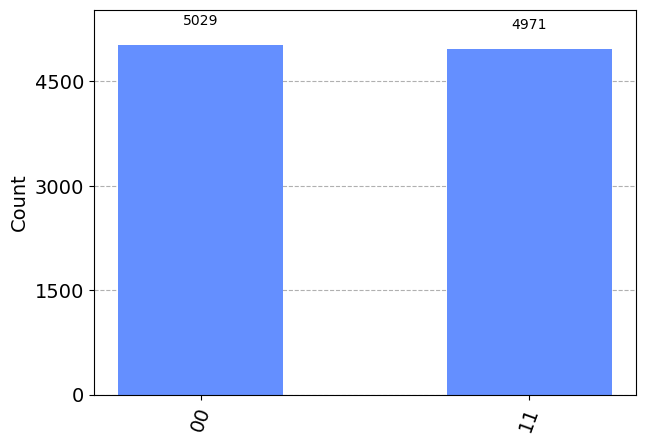

In [6]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)

#### Running on an estimator primitive

In [7]:
from qiskit.quantum_info import SparsePauliOp

observables = [
    SparsePauliOp('ZZ'),
    SparsePauliOp('ZI'),
    SparsePauliOp('IZ'),
    SparsePauliOp('XX'),
    SparsePauliOp('XI'),
    SparsePauliOp('IX')
]

observables

[SparsePauliOp(['ZZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['XX'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['XI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IX'],
               coeffs=[1.+0.j])]

In [8]:
from qiskit_ibm_runtime import EstimatorV2

estimator = EstimatorV2(backend=AerSimulator())

In [9]:
job = estimator.run([(circuit, observables)])

In [10]:
result = job.result()

In [11]:
result[0].data.evs

array([ 1.00000000e+00, -2.44140625e-03, -2.44140625e-03, -9.76562500e-04,
        3.41796875e-03, -9.27734375e-03])

### Application: Finding the Max-Cut of a graph

In [12]:
import networkx as nx

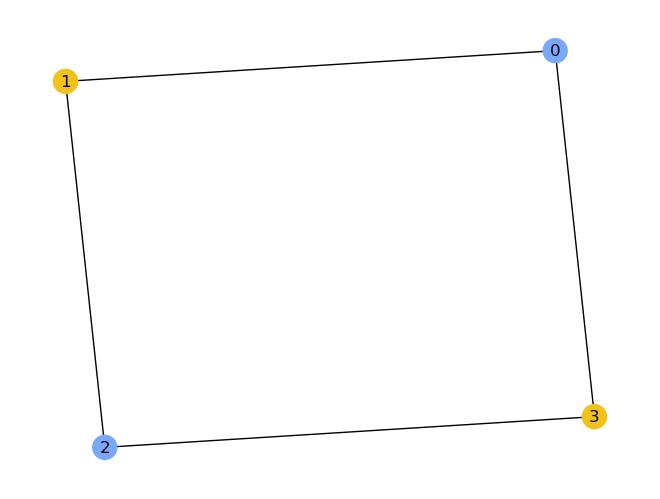

In [13]:
G = nx.Graph()
G.add_edge(0,1)
G.add_edge(1,2)
G.add_edge(2,3)
G.add_edge(3,0)

color_map = ['#78a9ff','#f1c21b','#78a9ff','#f1c21b']
nx.draw(G, node_color=color_map, with_labels=True)

#### Create circuit and observables

In [14]:
from qiskit.circuit import ParameterVector

def create_qaoa_circuit(num_qubits: int, depth: int = 1) -> QuantumCircuit:
    qaoa = QuantumCircuit(num_qubits, name='q')
    qaoa.h(range(num_qubits))

    gamma = ParameterVector('γ',depth)
    beta = ParameterVector('β',depth)

    for d in range(depth):
        # problem Hamiltonian
        for i in range(num_qubits-1):
            qaoa.rzz(gamma[d],i,i+1)
            
        qaoa.rzz(gamma[d],num_qubits-1,0)

        # mixer Hamiltonian
        for i in range(num_qubits):
            qaoa.rx(beta[d],i)
            
        if d != depth-1:
            qaoa.barrier()

    return qaoa

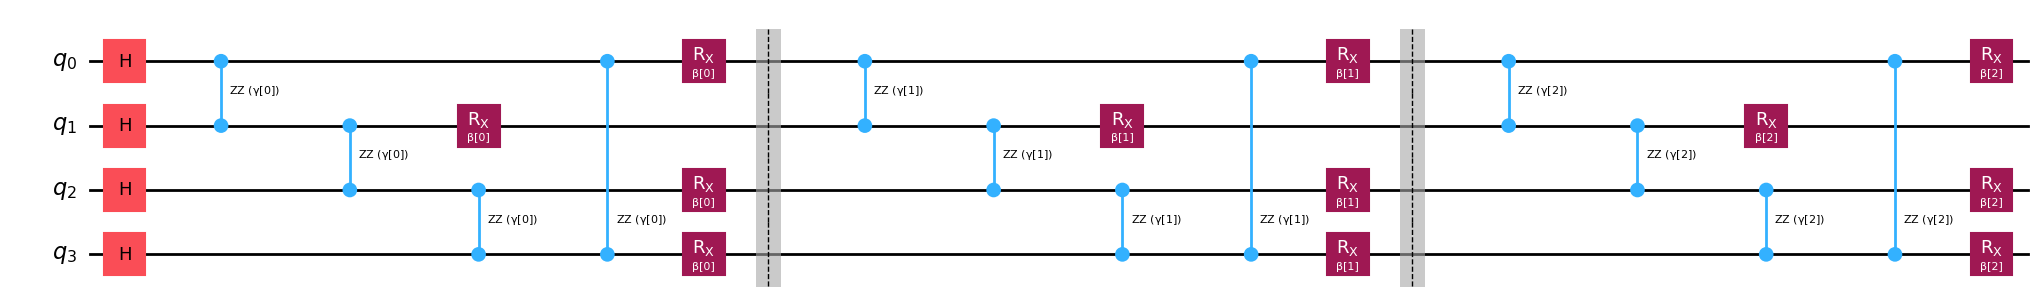

In [81]:
qaoa = create_qaoa_circuit(num_qubits=4,depth=3)
qaoa.draw('mpl',fold=-1)

In [82]:
observables = [
    SparsePauliOp('ZZII'),
    SparsePauliOp('IZZI'),
    SparsePauliOp('IIZZ'),
    SparsePauliOp('ZIIZ')
]

In [83]:
observables

[SparsePauliOp(['ZZII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IZZI'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIZZ'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZIIZ'],
               coeffs=[1.+0.j])]

#### Run optimization

In [84]:
init_params = [0]*qaoa.num_parameters
init_params

[0, 0, 0, 0, 0, 0]

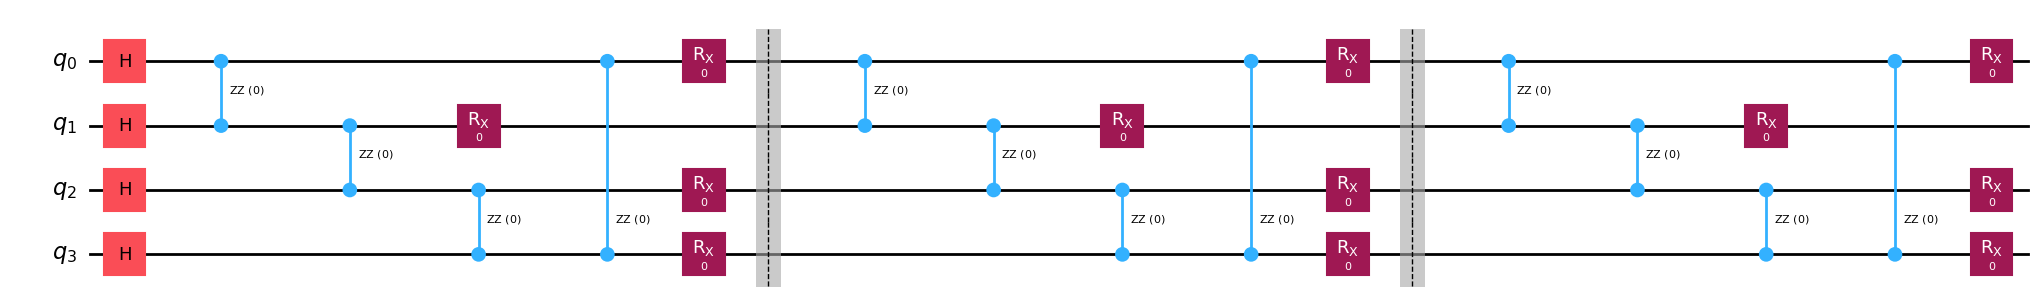

In [85]:
qaoa_params = qaoa.assign_parameters(init_params)
qaoa_params.draw('mpl', fold=-1)

In [86]:
def obtain_expval(params: list, qaoa: QuantumCircuit, observables: list, estimator) -> float:
    # execute the circuit
    job = estimator.run([(qaoa, observables, params)])
    result = job.result()[0]

    # sum up values
    value = sum(result.data.evs)

    return value

In [90]:
from scipy.optimize import minimize

ideal_res = minimize(
    obtain_expval, init_params, args=(qaoa.copy(), observables, estimator), method="cobyla"
)

In [91]:
ideal_res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.8408203125
       x: [ 9.305e-01  1.286e+00 -1.274e-02 -1.271e+00 -9.527e-01
            1.653e+00]
    nfev: 79
   maxcv: 0.0

In [109]:
ideal_expval = ideal_res.fun

In [92]:
ideal_res.x

array([ 0.93051221,  1.28584268, -0.01274331, -1.27060888, -0.95265272,
        1.65311694])

#### Obtain the resulting distribution

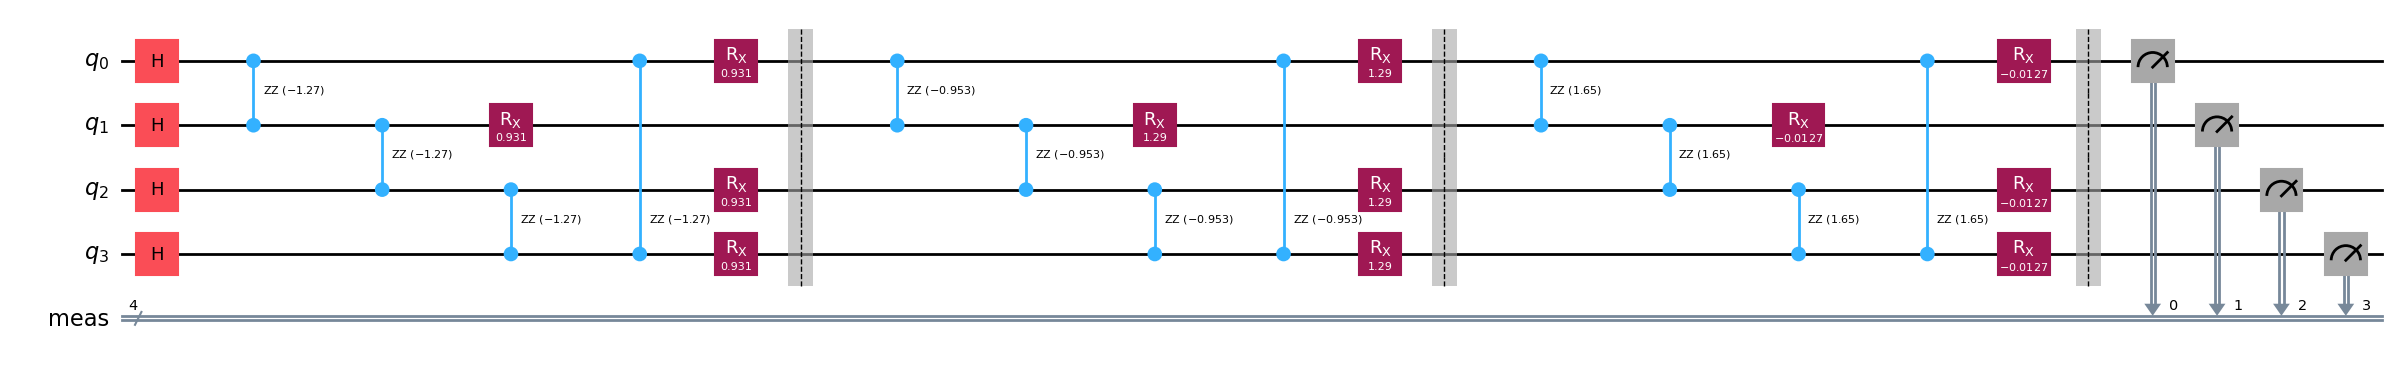

In [93]:
qaoa.assign_parameters(ideal_res.x, inplace=True)
qaoa.measure_all()
qaoa.draw('mpl',fold=-1)

In [94]:
job = sampler.run([qaoa])
result = job.result()[0]
counts = result.data.meas.get_counts()

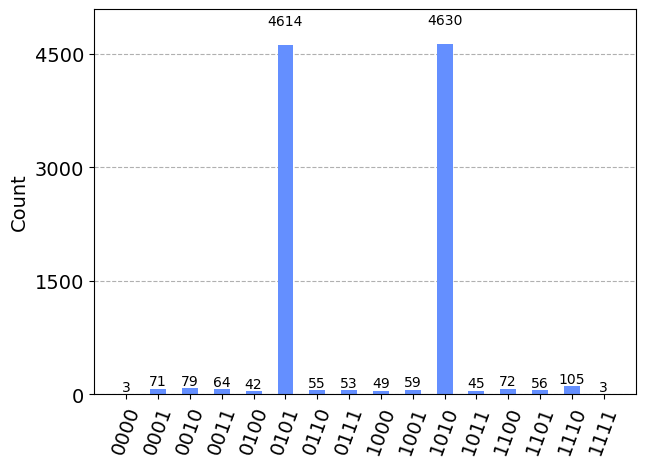

In [95]:
plot_histogram(counts)

### Running on a (fake) backend

In [96]:
from qiskit_ibm_runtime.fake_provider import FakeKolkata

backend = FakeKolkata()

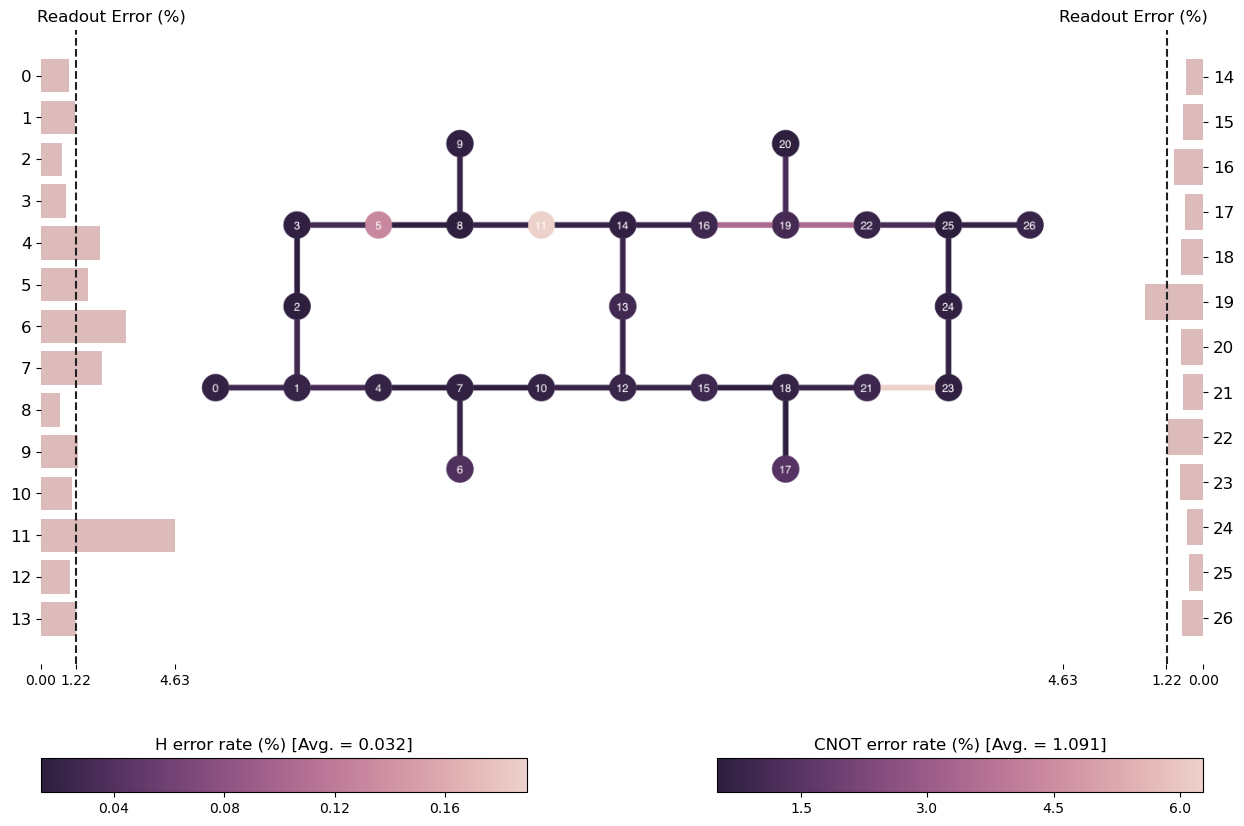

In [97]:
from qiskit.visualization import plot_error_map

plot_error_map(backend, show_title=False)

In [98]:
config = backend.configuration()
print(
    64 * "#",
    "\nConfiguration for: {}, version: {}".format(
        config.backend_name, config.backend_version
    ),
)
print("  Number of Qubits: {}".format(config.n_qubits))
print("  Basis Gates: {}".format(config.basis_gates))

################################################################ 
Configuration for: fake_kolkata, version: 1.9.9
  Number of Qubits: 27
  Basis Gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']


#### Transpile circuit

In [99]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=1, coupling_map=backend.configuration().coupling_map, basis_gates=['x','sx','rz','cx','id','swap'])

In [100]:
trans_circuit = pm.run(qaoa)

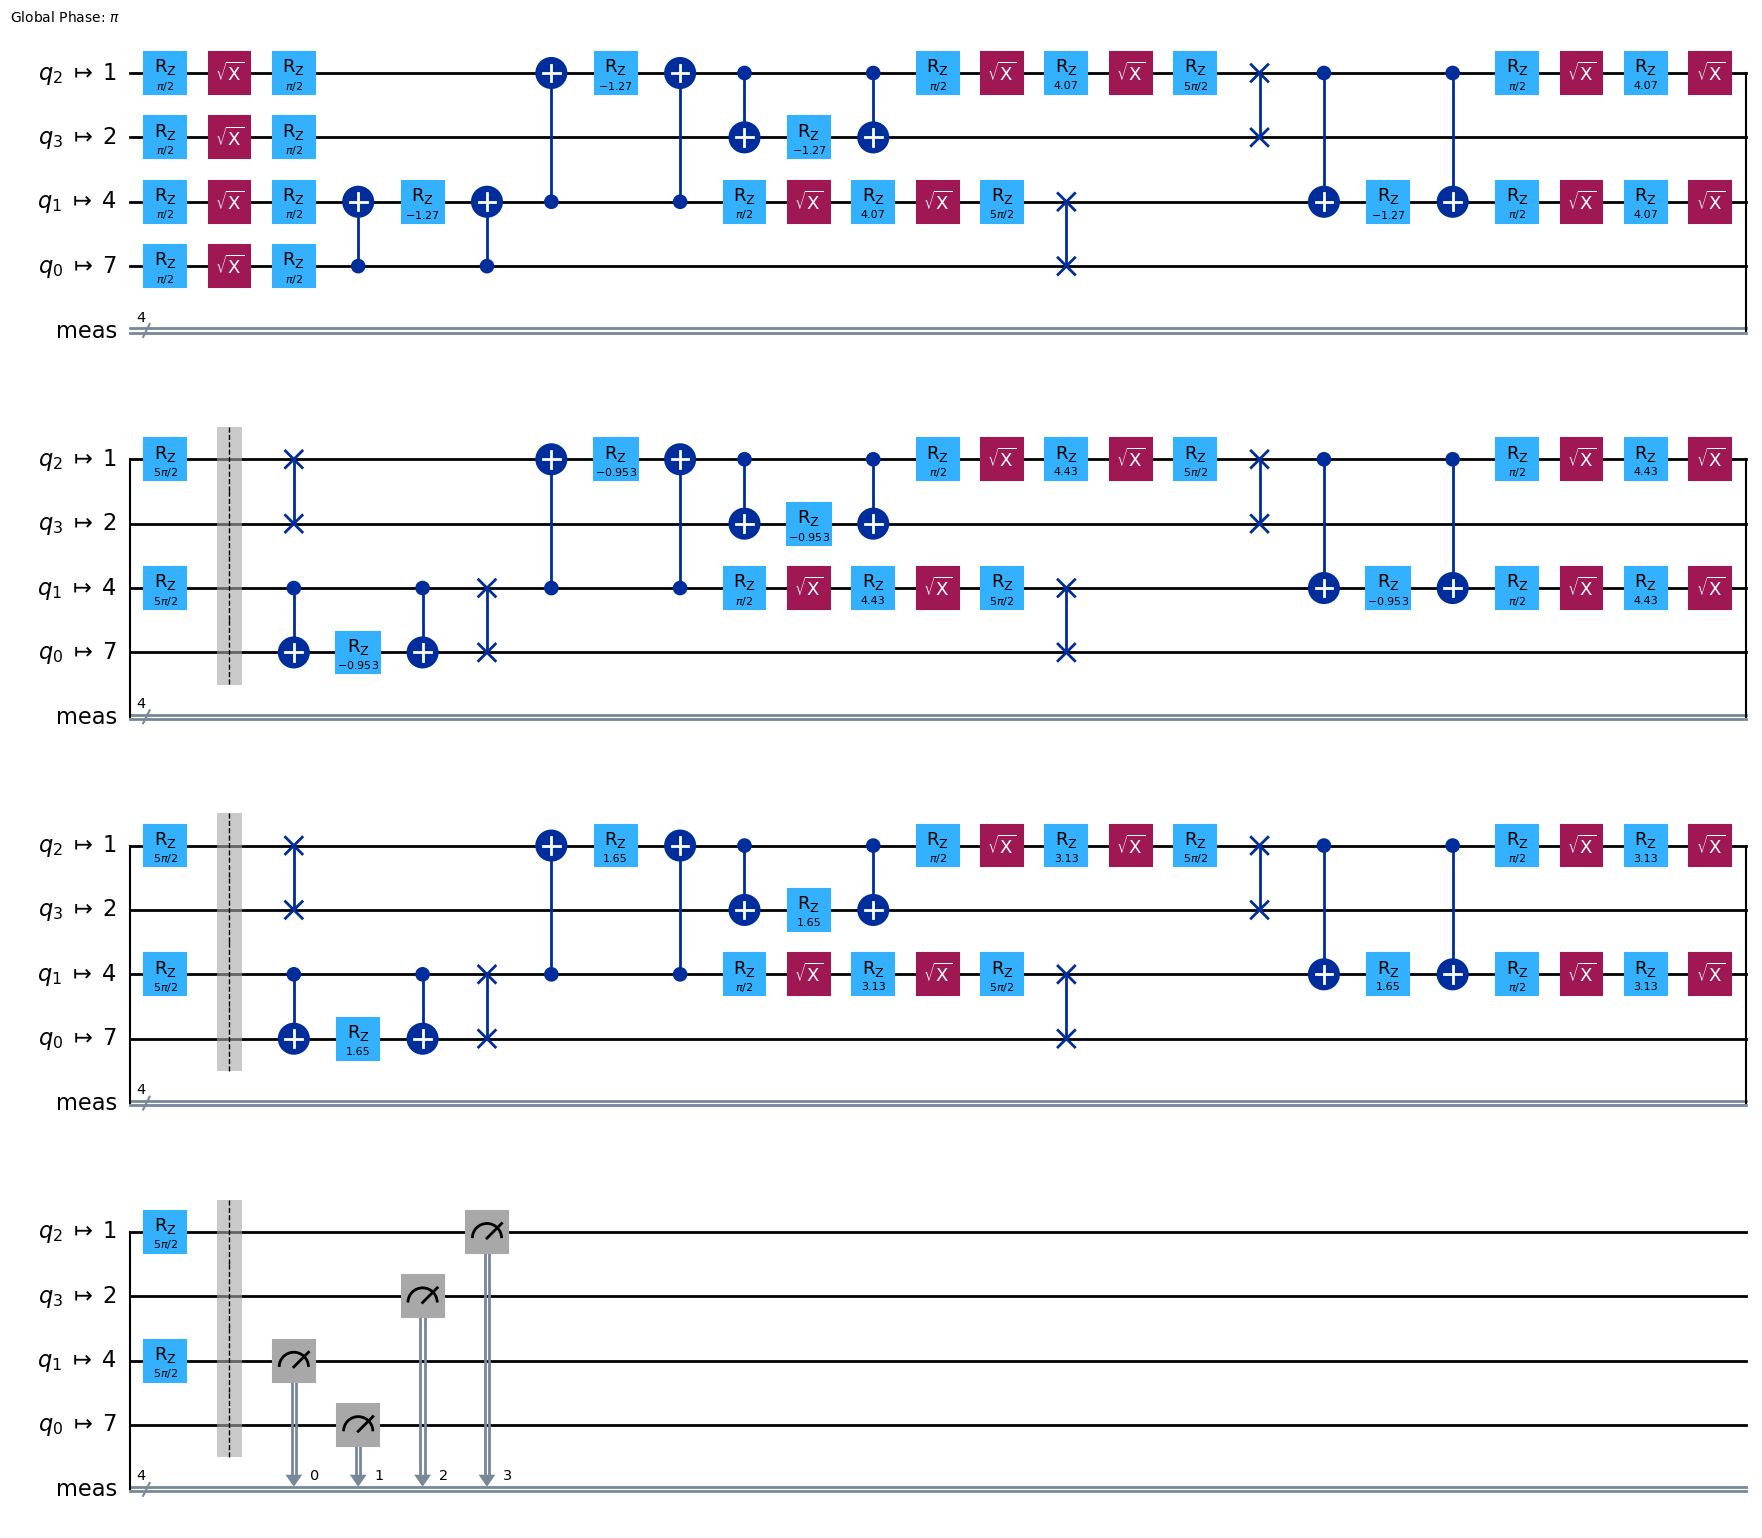

In [101]:
trans_circuit.draw('mpl',idle_wires=False)

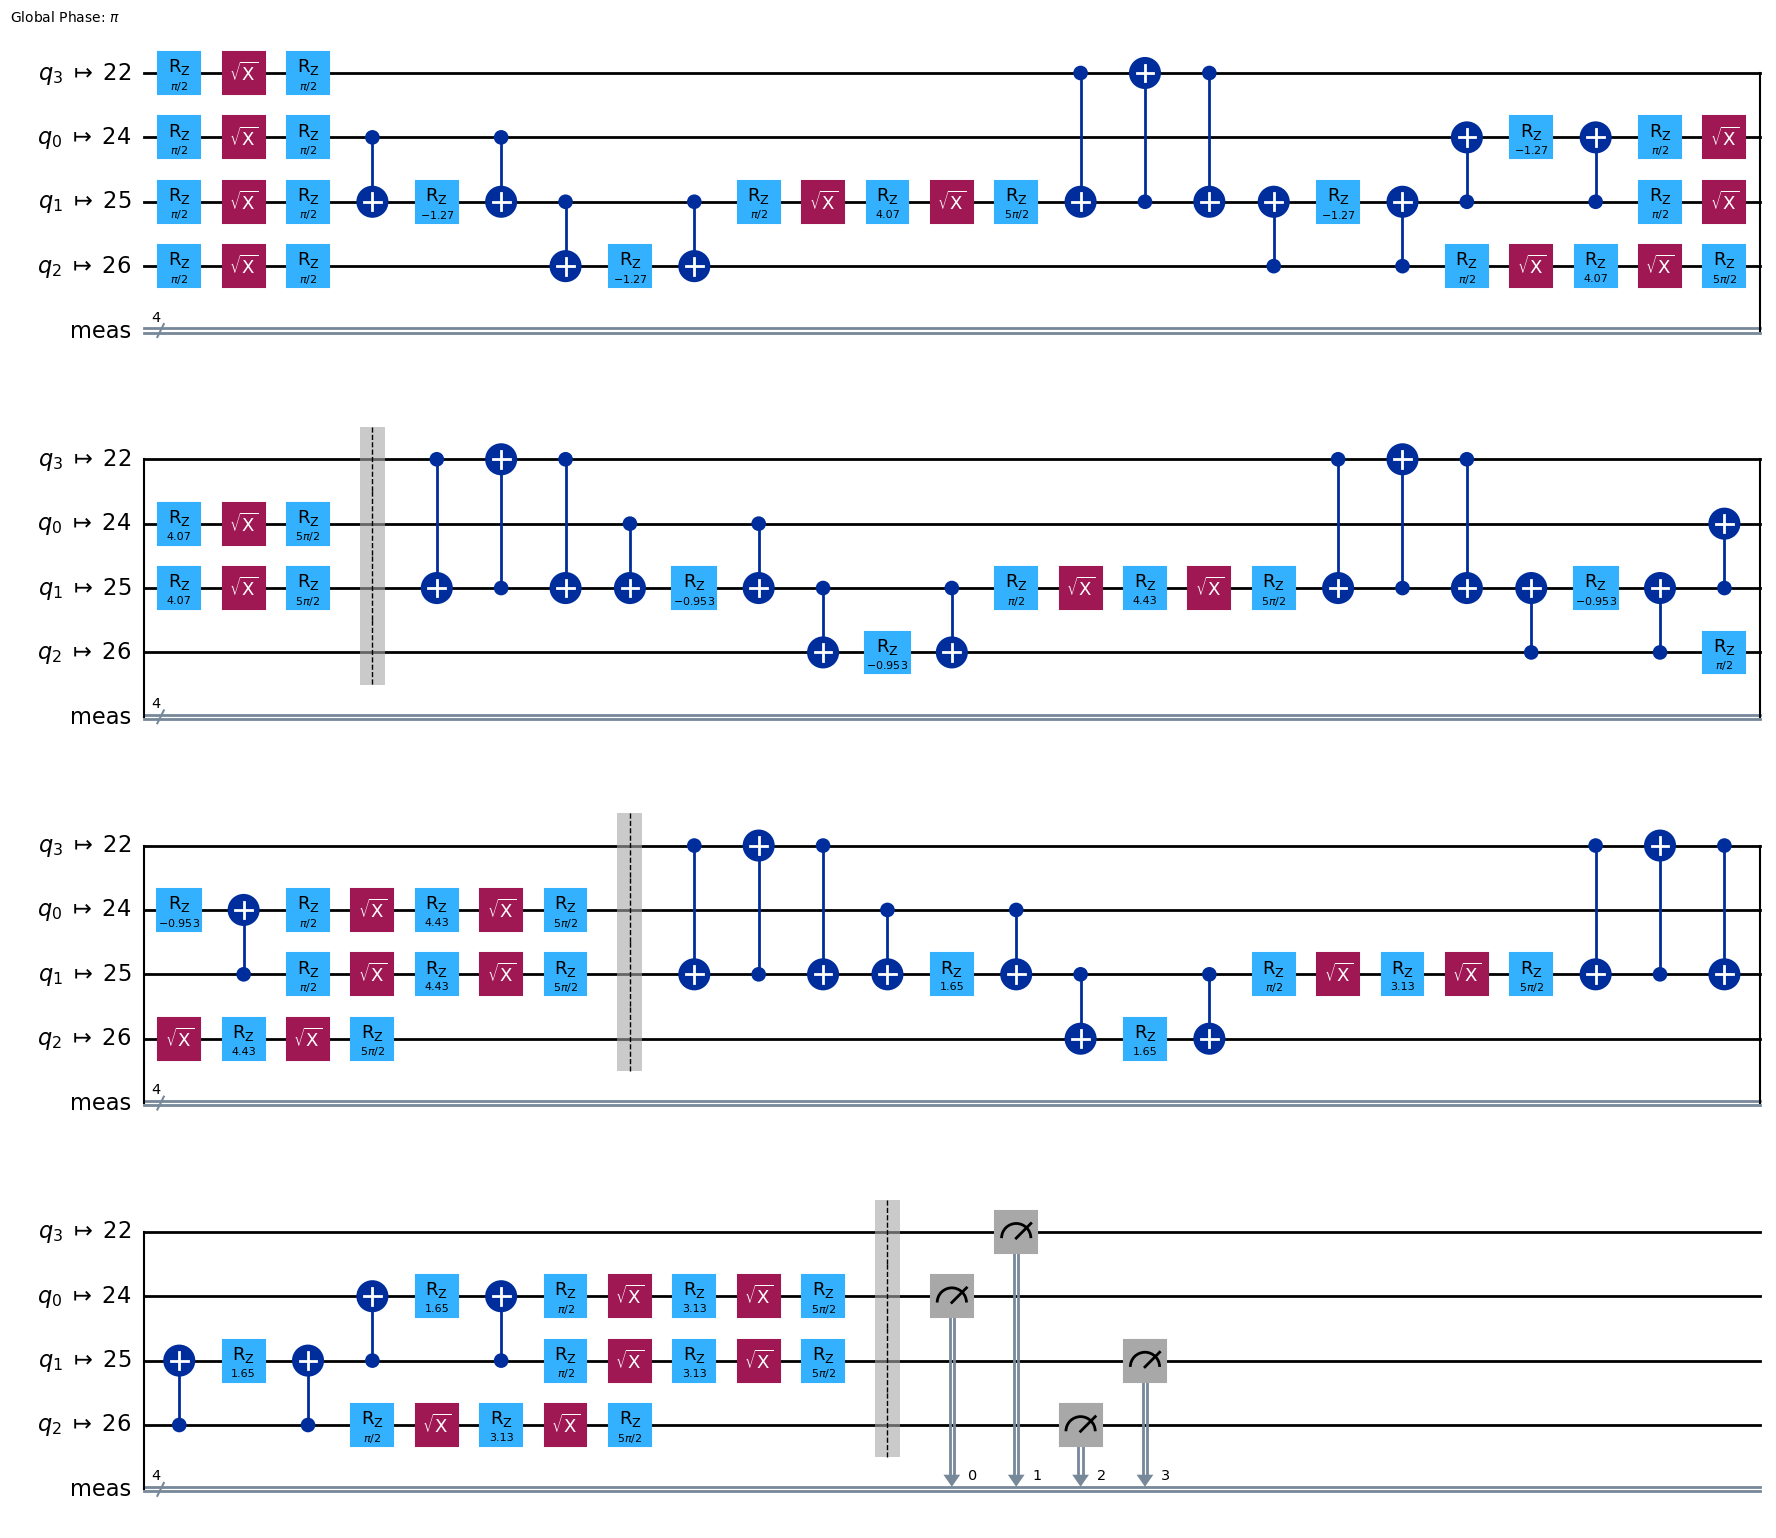

In [102]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
trans_circuit = pm.run(qaoa)
trans_circuit.draw('mpl',idle_wires=False)

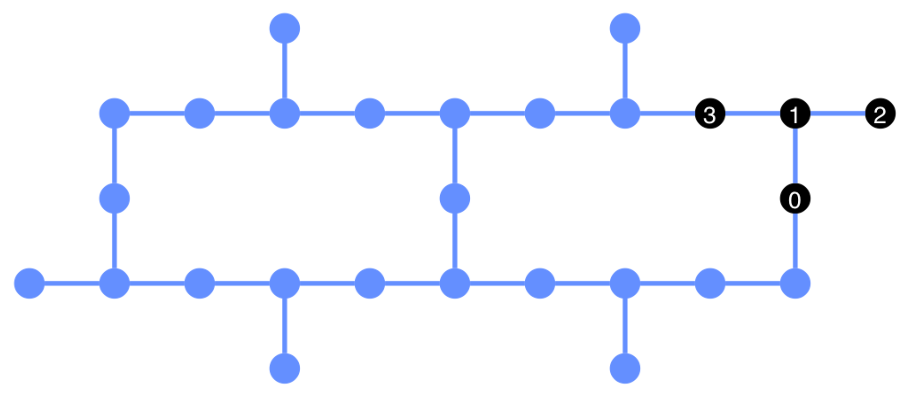

In [103]:
from qiskit.visualization import plot_circuit_layout

plot_circuit_layout(trans_circuit, backend)

#### Execute

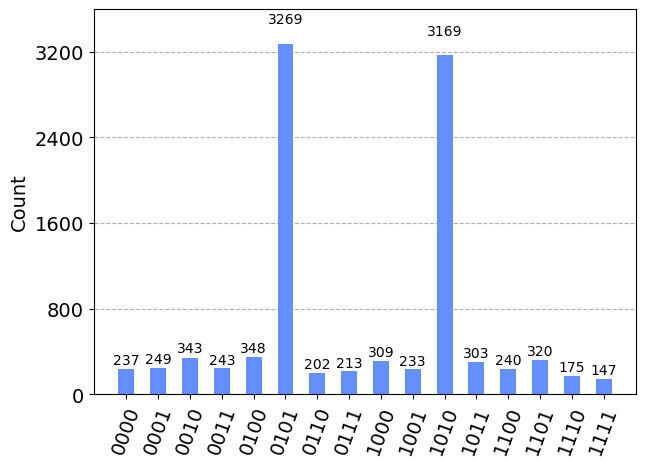

In [104]:
from qiskit_ibm_runtime.fake_provider import FakeHanoi
sampler = SamplerV2(backend=FakeHanoi())
sampler.options.default_shots = 10000

job = sampler.run([trans_circuit])
result = job.result()[0]
counts = result.data.meas.get_counts()

plot_histogram(counts)

### Error mitigation: Zero Noise Extrapolation

#### Noisy expectation value

In [105]:
noisy_estimator = EstimatorV2(backend=backend)

In [106]:
isa_observables = [obs.apply_layout(trans_circuit.layout) for obs in observables]
isa_observables

[SparsePauliOp(['ZZIIIIIIIIIIIIIIIIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['ZIIIZIIIIIIIIIIIIIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IIZIZIIIIIIIIIIIIIIIIIIIIII'],
               coeffs=[1.+0.j]),
 SparsePauliOp(['IZZIIIIIIIIIIIIIIIIIIIIIIII'],
               coeffs=[1.+0.j])]

In [107]:
noisy_job = noisy_estimator.run([(trans_circuit, isa_observables)])

In [110]:
noisy_result = noisy_job.result()[0]
ns_expvals = noisy_result.data.evs

In [111]:
ns_expvals

array([-0.68505859, -0.67724609, -0.6484375 , -0.68164062])

In [112]:
noisy_expval = sum(ns_expvals)
noisy_expval

-2.6923828125

#### Amplify circuit

In [113]:
from zne.noise_amplification import LocalFoldingAmplifier

amplifier = LocalFoldingAmplifier(gates_to_fold=2)

##### Noise factor 1.2

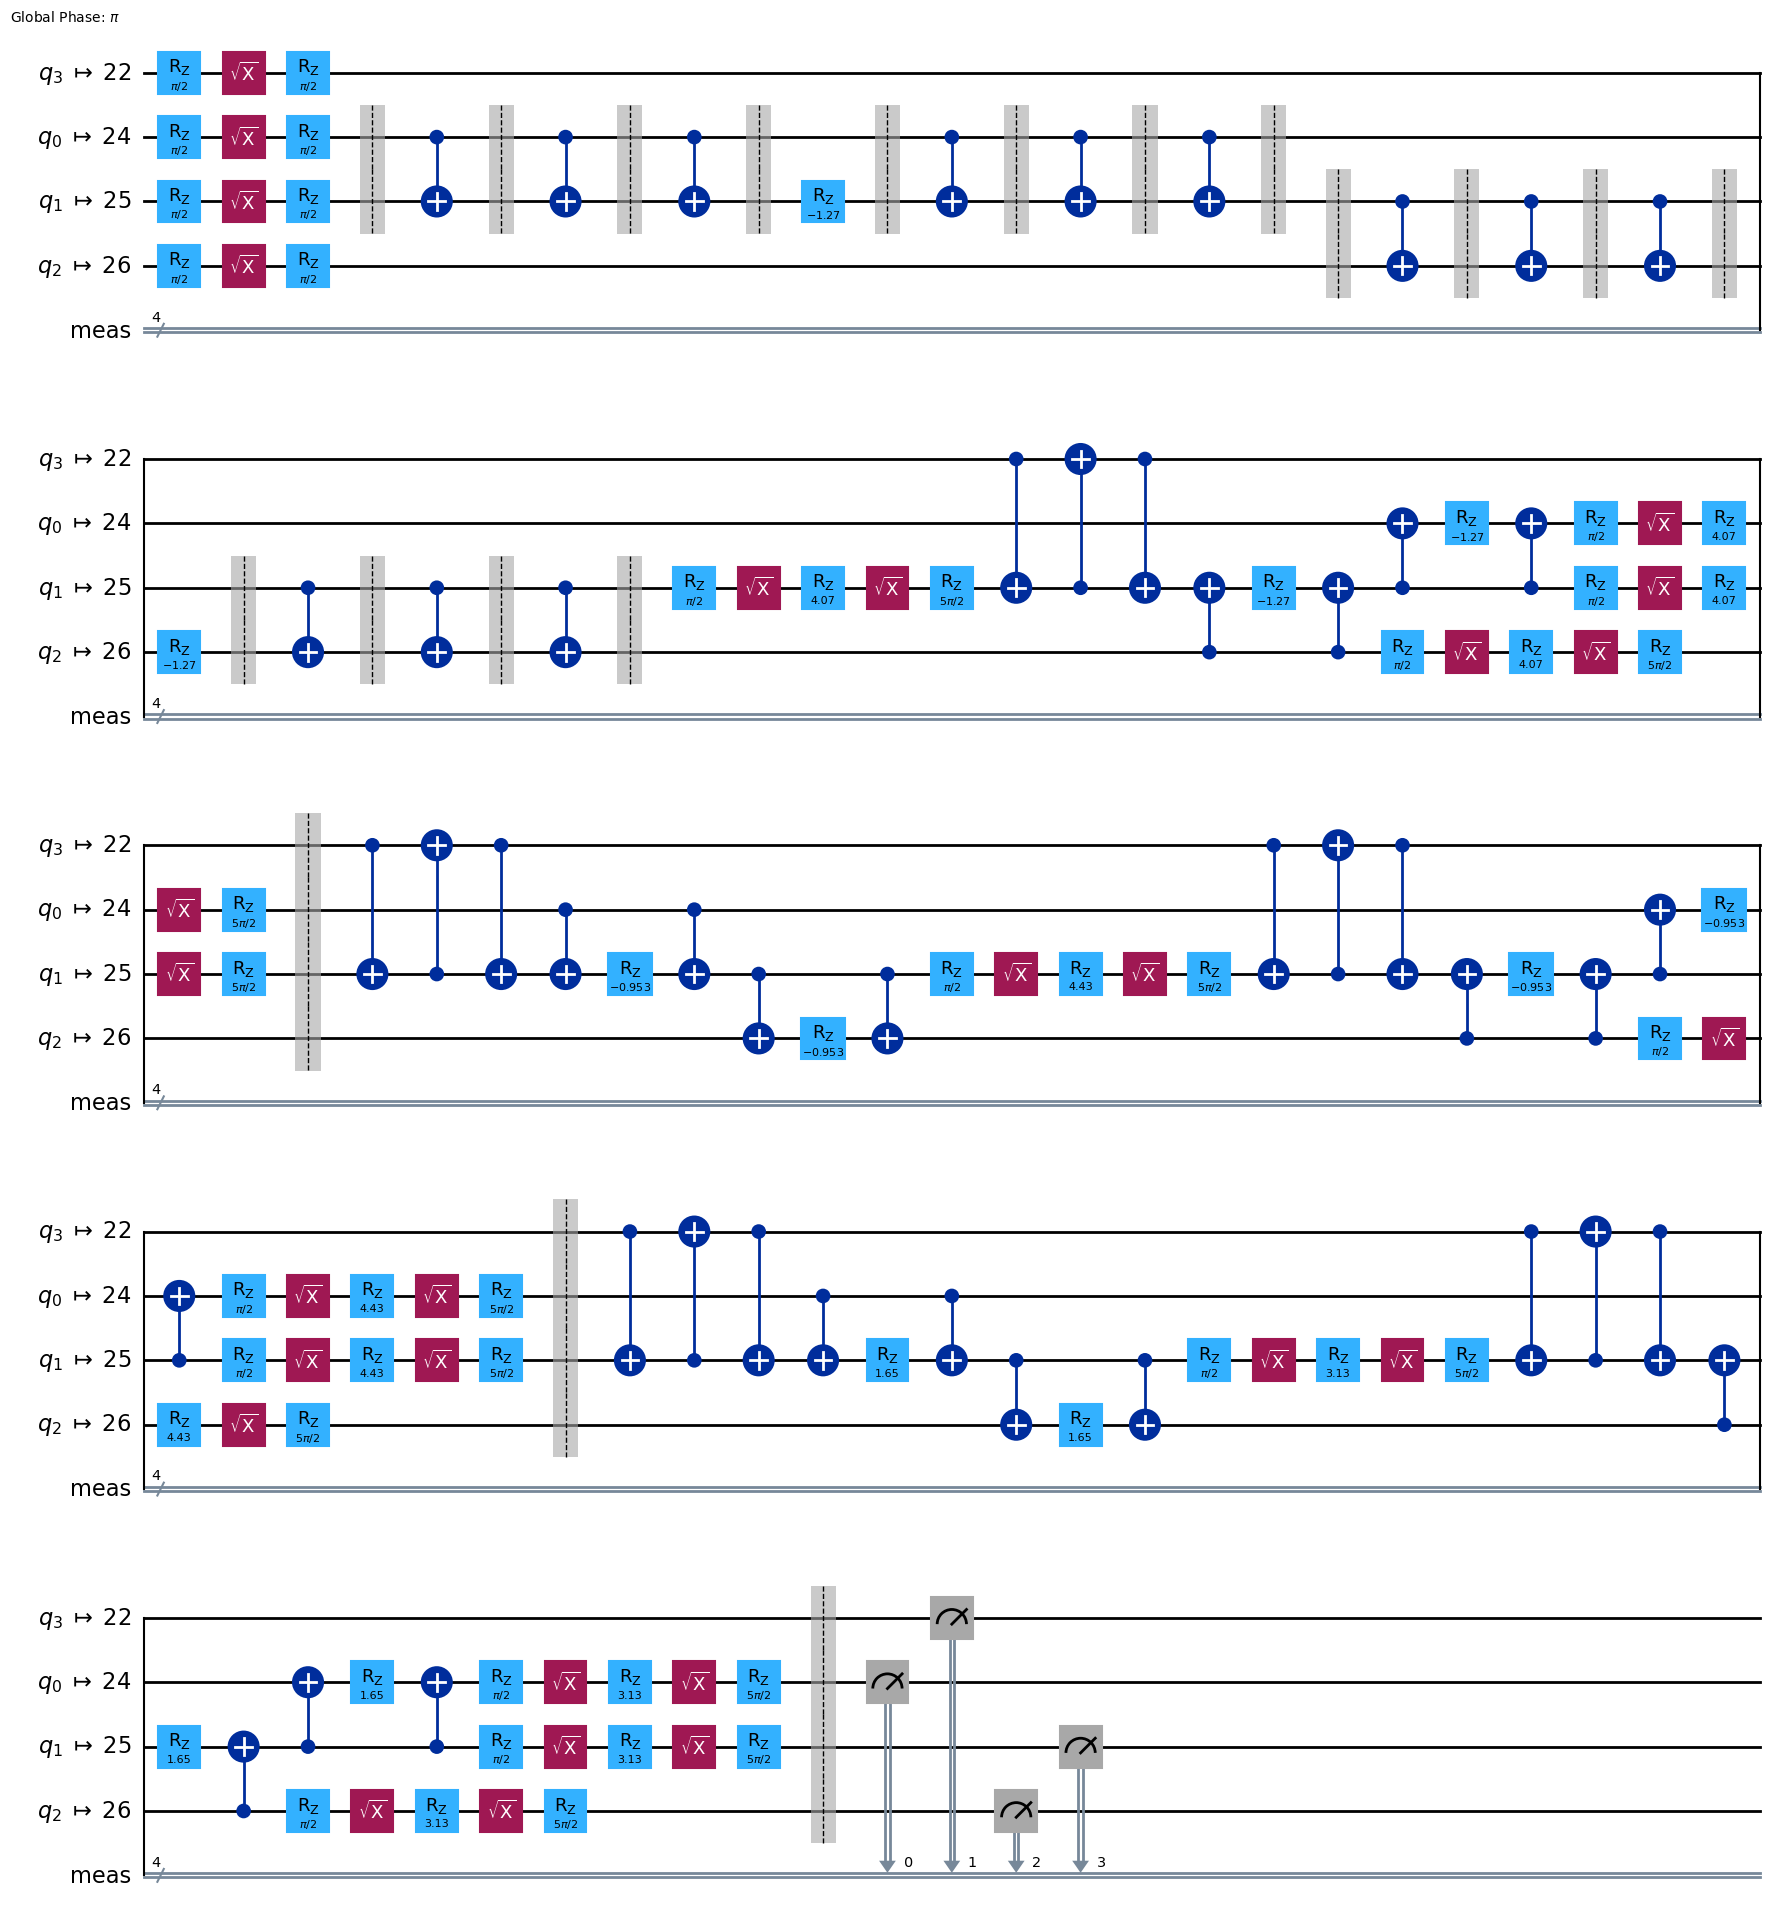

In [114]:
amplified_circuit = amplifier.amplify_circuit_noise(trans_circuit, noise_factor=1.2)
amplified_circuit.draw('mpl', idle_wires=False)

In [115]:
amplified_job = noisy_estimator.run([(amplified_circuit, isa_observables)])

In [116]:
amplified_result = amplified_job.result()[0]
amplified_expval = sum(amplified_result.data.evs)

In [117]:
amplified_expval

-2.4853515625

##### Noise factor 1.4

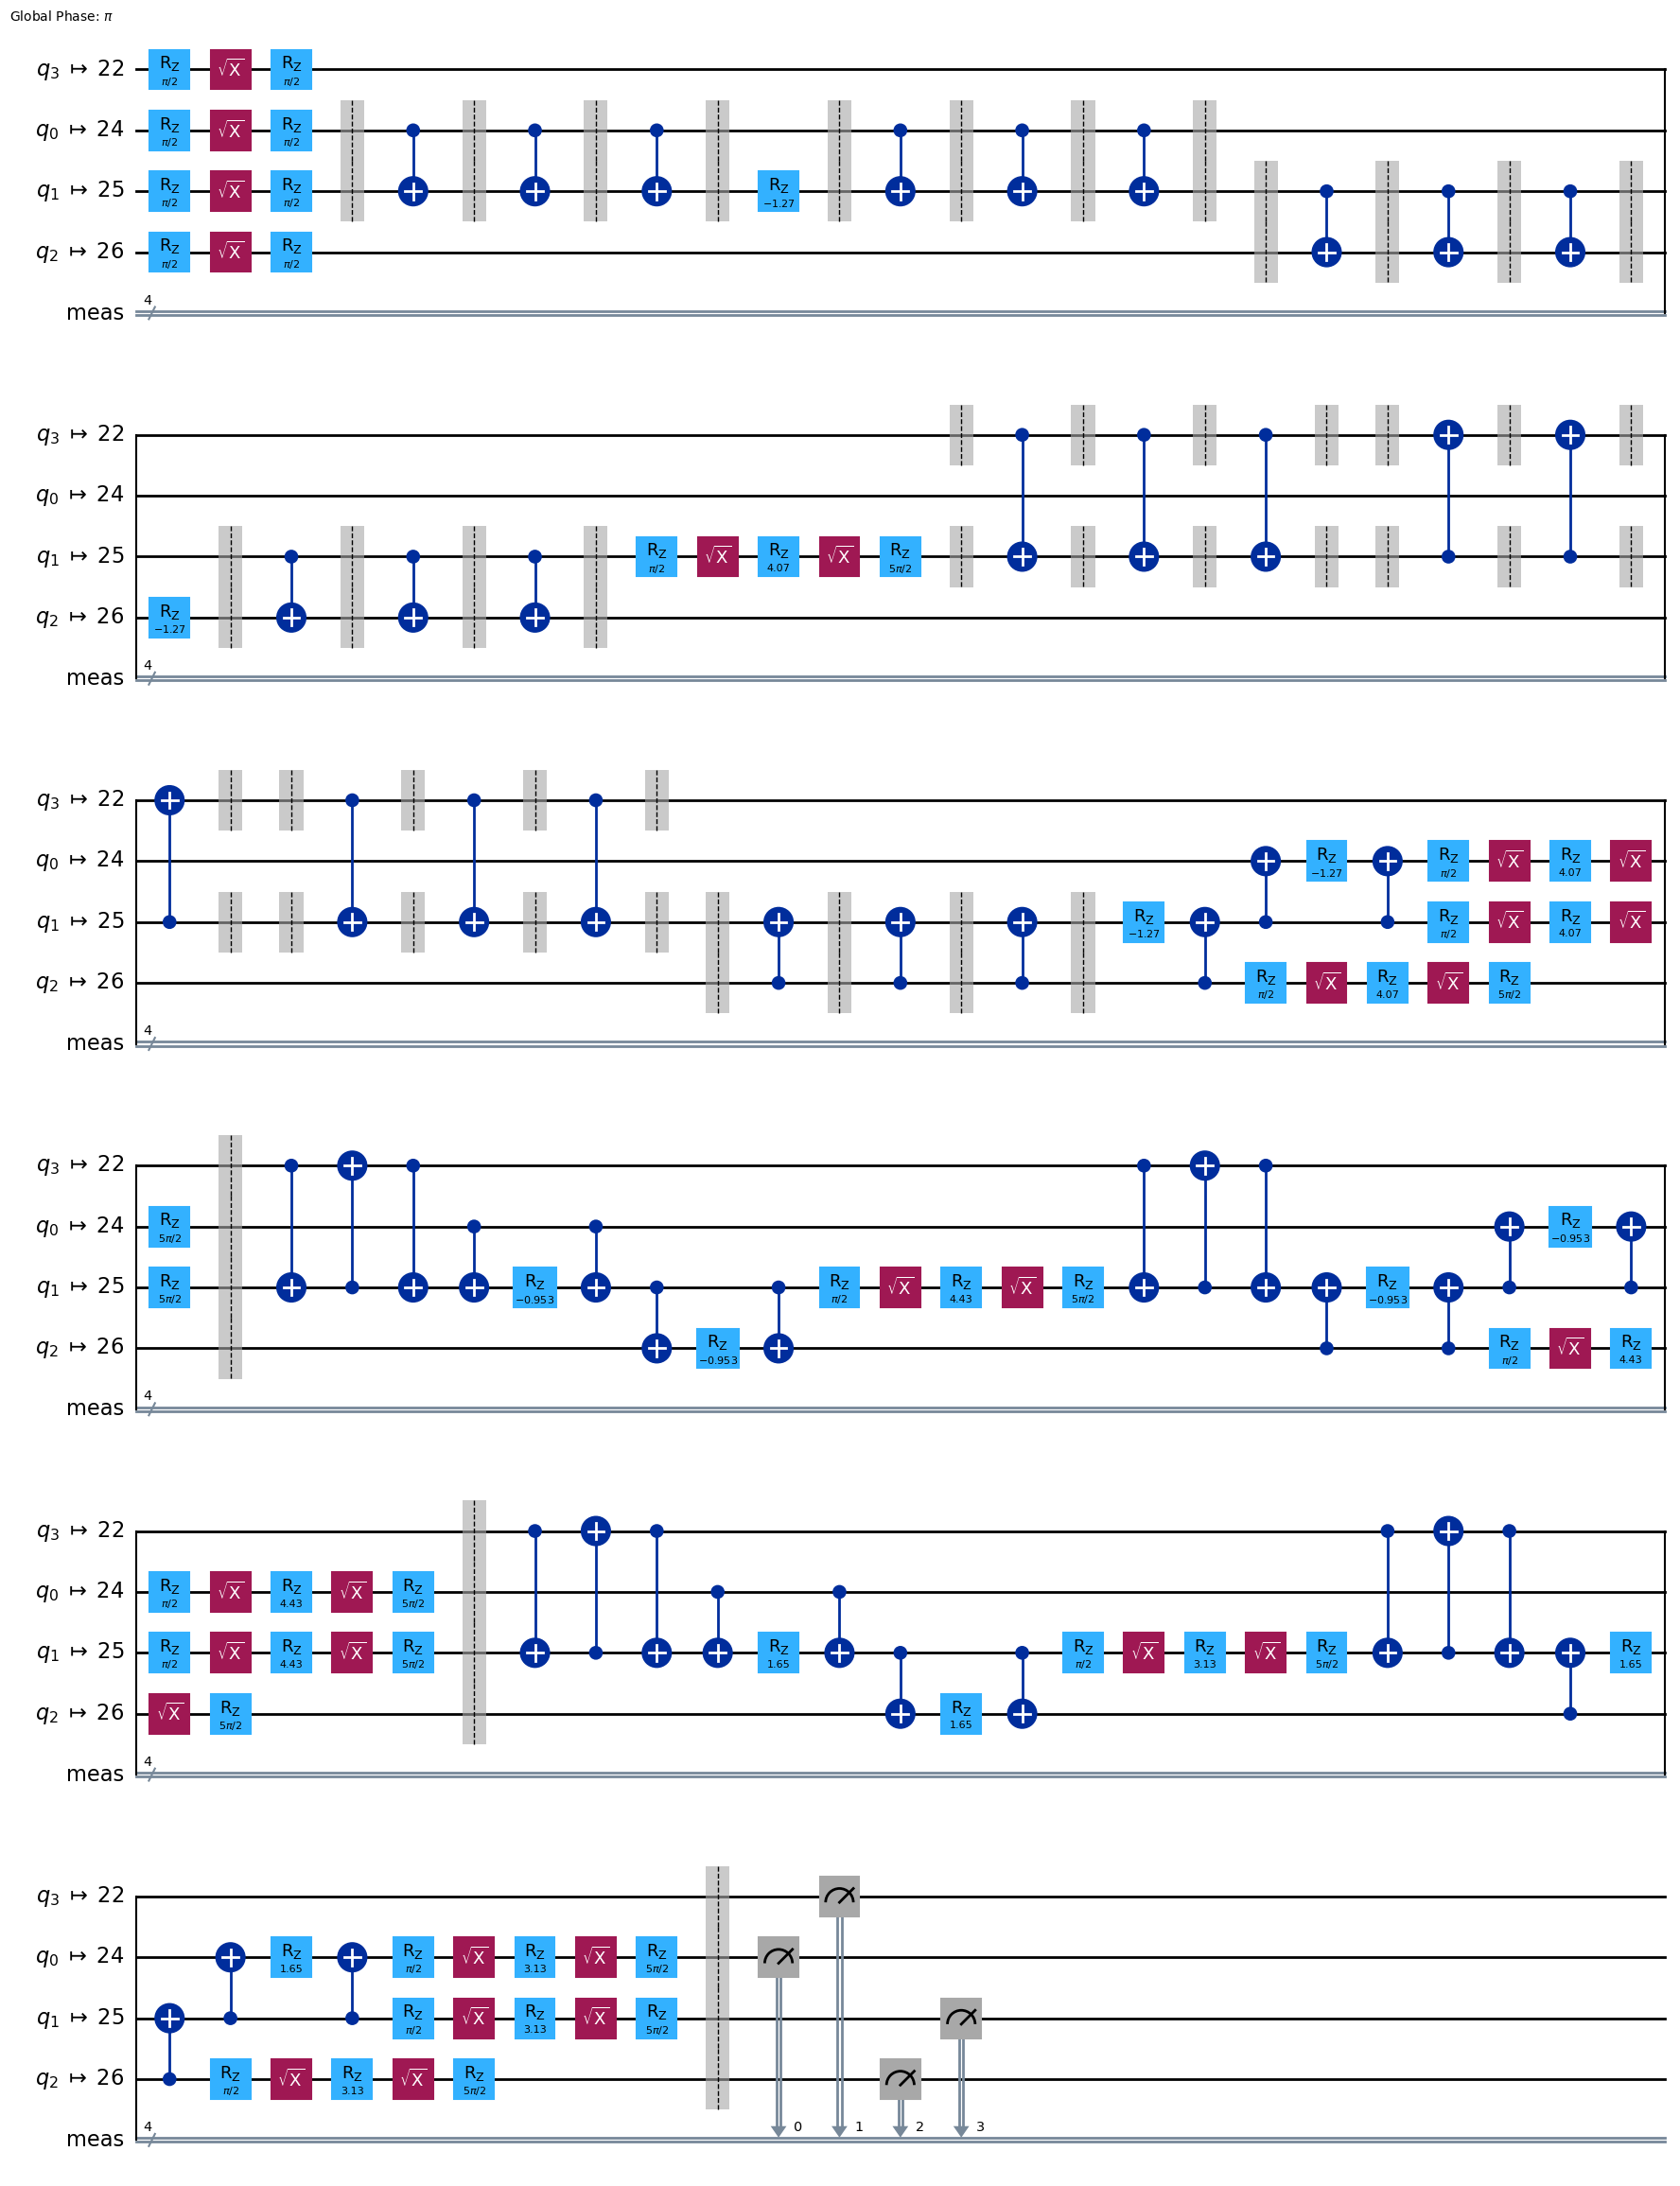

In [118]:
amplified_circuit2 = amplifier.amplify_circuit_noise(trans_circuit, noise_factor=1.4)
amplified_circuit2.draw('mpl', idle_wires=False)

In [119]:
amplified_job2 = noisy_estimator.run([(amplified_circuit2, isa_observables)])

In [120]:
amplified_result2 = amplified_job2.result()[0]
amplified_expval2 = sum(amplified_result2.data.evs)

In [121]:
amplified_expval2

-2.2880859375

#### Plotting the noisy expectation values

In [122]:
nf = [1, 1.2, 1.4]
expvals = [noisy_expval, amplified_expval, amplified_expval2]

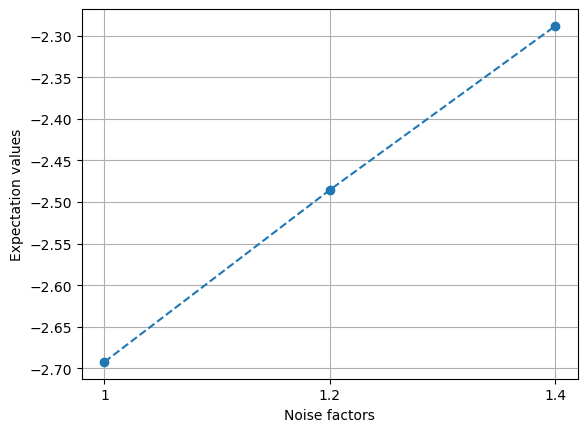

In [125]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(nf, expvals, 'o--')
plt.xticks([1,1.2,1.4],['1', '1.2', '1.4'])
plt.grid()
plt.ylabel('Expectation values')
plt.xlabel('Noise factors')
plt.show()

#### Extrapolate to zero

In [126]:
from zne.extrapolation import LinearExtrapolator

extrapolator = LinearExtrapolator()

In [127]:
extrapolated_expval = extrapolator.extrapolate_zero(nf, expvals).value

In [128]:
extrapolated_expval

-3.701497395833333

#### Plot the result

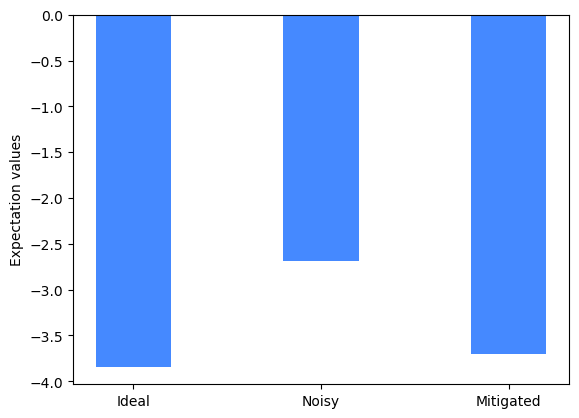

In [130]:
plt.bar(['Ideal', 'Noisy', 'Mitigated'], [ideal_expval, noisy_expval, extrapolated_expval], color ='#4589ff', width = 0.4)
plt.ylabel('Expectation values')
plt.show()

### Using Qiskit Primitives

In [131]:
estimator = EstimatorV2(backend=backend)
estimator.options.default_shots = 10000
estimator.options.resilience.zne_mitigation = True
estimator.options.resilience.zne.noise_factors = [1,1.2,1.4]
estimator.options.resilience.zne.extrapolator = 'linear'

`estimator.run([(trans_circuit, isa_observables)])`